#### Importations

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from yolo_dataset_stats import DatasetAnalyzer
import matplotlib.pyplot as plt
import random
from math import sin, cos, radians
import yaml

## L-System inspired tree generator 

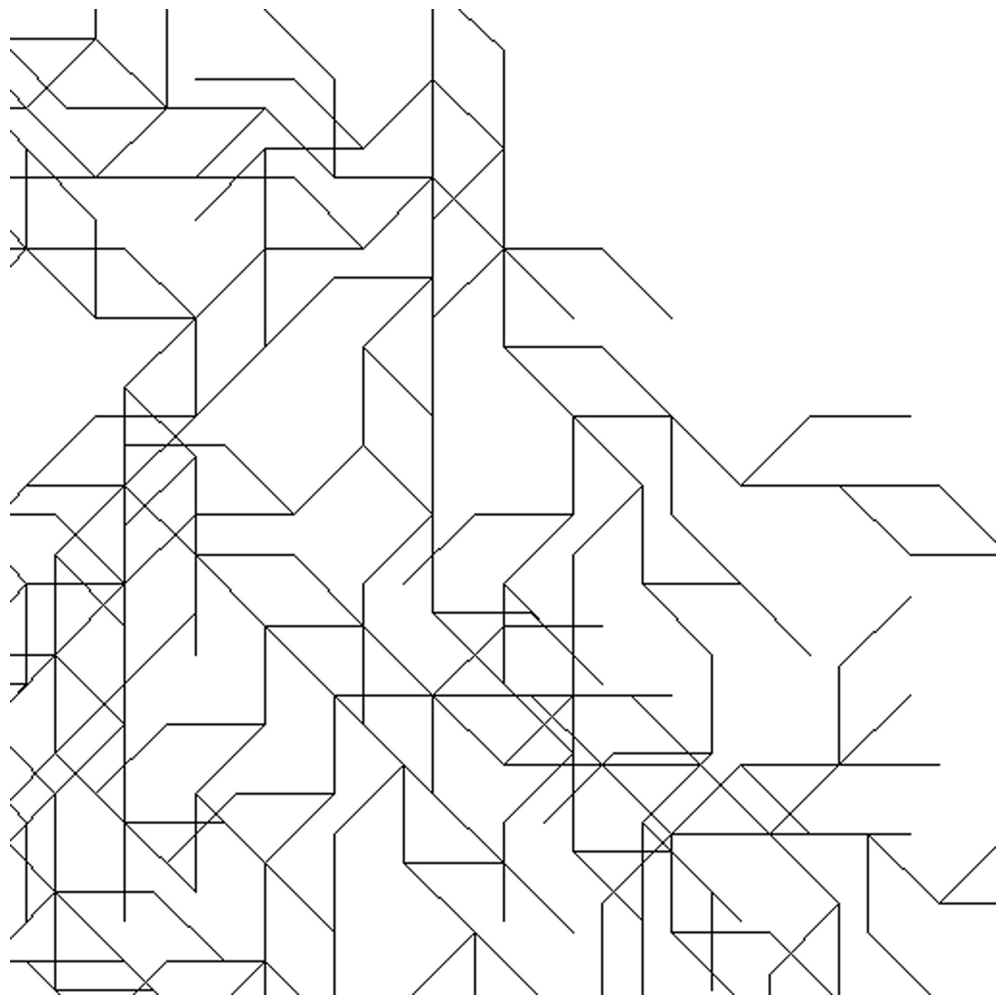

In [2]:
# inspired by my previous work on fractal generation : https://github.com/VendenIX/Generateur-de-flore-video-ludique
def generate_fractal_template(small_img_size=512, final_img_size=1280, iterations=5, angle=45, length_factor=10, rate=50):
    axiom = "F"
    rules = {
        "F": "1F+[+X-F]X-[-F+X]X",
        "X": "[-F+F]F[-F+F]"
    }
    optional_rule = ("X", "[-]")  # règle optionnelle avec 50 % de chance
    length = small_img_size / length_factor  # longueur ajustée pour l'image 512x512

    def apply_rules(axiom, rules, optional_rule, rate, iterations):
        for _ in range(iterations):
            new_axiom = ""
            for char in axiom:
                if char in rules:
                    if char == optional_rule[0] and random.randint(0, 100) < rate:
                        new_axiom += optional_rule[1]
                    else:
                        new_axiom += rules[char]
                else:
                    new_axiom += char
            axiom = new_axiom
        return axiom

    def draw_lsystem(axiom, angle, length, img_size):
        stack = []
        x, y = img_size // 2, -int(img_size * 0.2) 
        current_angle = 90
        img = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255 

        for command in axiom:
            if command == "F" or command == "X":
                new_x = x + length * cos(radians(current_angle))
                new_y = y + length * sin(radians(current_angle))
                cv2.line(img, (int(x), int(y)), (int(new_x), int(new_y)), (0, 0, 0), 1) 
                x, y = new_x, new_y
            elif command == "+":
                current_angle += angle
            elif command == "-":
                current_angle -= angle
            elif command == "[":
                stack.append((x, y, current_angle))
            elif command == "]":
                x, y, current_angle = stack.pop()

        return img

    final_axiom = apply_rules(axiom, rules, optional_rule, rate, iterations)
    small_img = draw_lsystem(final_axiom, angle, length, small_img_size)

    final_img = cv2.resize(small_img, (final_img_size, final_img_size), interpolation=cv2.INTER_CUBIC)

    return final_img

template_image = generate_fractal_template()

plt.figure(figsize=(12.8, 12.8))
plt.axis("off")
plt.imshow(cv2.cvtColor(template_image, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
# config du dataset
dataset_dir = "custom_generated_dataset_yolo_with_lines"
images_dir = os.path.join(dataset_dir, "images")
labels_dir = os.path.join(dataset_dir, "labels")

# création des sous-dossiers pour train, val et test
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(images_dir, split), exist_ok=True)
    os.makedirs(os.path.join(labels_dir, split), exist_ok=True)

# paramètres de generation
num_imgs = 500
img_size = 1280
min_object_size = 30
max_object_size = 100
num_objects_per_image = np.random.randint(10, 50)

shape_to_class_id = {
    "homme": 0, "femme": 1, "homme decede": 2, "femme decede": 3,
    "homme atteint decede": 4, "femme atteinte decedee": 5,
    "index": 6, "homme atteint": 7, "femme atteinte": 8
}

def draw_bounding_box(class_id, x, y, size, img_size):
    x_center = (x + size / 2) / img_size
    y_center = (y + size / 2) / img_size
    width    = size / img_size
    height   = size / img_size
    return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

def rotate_shape(image, center, angle):
    h, w            = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated         = cv2.warpAffine(image, rotation_matrix, (w, h), borderMode=cv2.BORDER_REPLICATE)
    return rotated

def draw_rotated_rectangle(image, x, y, size, color, angle):
    # limite de la taille pour éviter des rectangles anormalement grands
    max_size = min(image.shape[0], image.shape[1]) // 5 # 1/5 de la taille de l'image
    size = min(size, max_size)
    
    rectangle = np.ones_like(image) * 255
    cv2.rectangle(rectangle, (x, y), (x + size, y + size), color, -1)

    center = (x + size // 2, y + size // 2)

    rotated_rectangle = rotate_shape(rectangle, center, angle)
    
    image = cv2.bitwise_and(image, rotated_rectangle)
    return image

def draw_rotated_arrow(image, x, y, length, width, color, angle):
    max_length = image.shape[1] // 10  # limite maximale de la longueur de la flèche (1/10 de la largeur)
    length     = min(length, max_length)

    # ajuste la longueur de la flèche pour qu'elle ne dépasse pas les limites de l'image
    if x + length >= image.shape[1]:  # limite à droite
        length = image.shape[1] - x - 1
    if x - length < 0:  # limite à gauche
        length = x - 1
    if y + width >= image.shape[0]:  # limite en bas pour la largeur
        width = image.shape[0] - y - 1

    # dessiner le corps de la flèche
    arrow = np.ones_like(image) * 255
    body_length = int(length * 0.7)
    end_x = x + body_length
    cv2.rectangle(arrow, (x, y - width // 2), (end_x, y + width // 2), color, -1)

    # dessiner la pointe de la flèche
    tip_x = x + length
    tip_points = np.array([[tip_x, y], [end_x, y - width], [end_x, y + width]])
    cv2.fillPoly(arrow, [tip_points], color)

    # rotation de la flèche autour de son centre
    center = (x + body_length // 2, y)
    rotated_arrow = rotate_shape(arrow, center, angle)
    image = cv2.bitwise_and(image, rotated_arrow)

    return image

def create_image_with_custom_shapes(img_size, num_objects, min_size, max_size):
    image       = generate_fractal_template()
    annotations = []
    centers     = []  # Liste des centres pour tracer les lignes de connexion

    for _ in range(num_objects):
        shape_type = np.random.choice(list(shape_to_class_id.keys()))
        size       = np.random.randint(min_size, max_size)
        x          = np.random.randint(0, img_size - size)
        y          = np.random.randint(0, img_size - size)
        angle      = np.random.randint(0, 360)

        # Dessiner les formes et ajouter leurs centres pour les connexions
        if shape_type == "homme":
            image = draw_rotated_rectangle(image, x, y, size, (0, 0, 0), angle)
            centers.append((x + size // 2, y + size // 2))

        elif shape_type == "femme":
            circle         = np.ones_like(image) * 255
            cv2.circle(circle, (x + size // 2, y + size // 2), size // 2, (0, 0, 0), 2)
            rotated_circle = rotate_shape(circle, (x + size // 2, y + size // 2), angle)
            image          = cv2.bitwise_and(image, rotated_circle)
            centers.append((x + size // 2, y + size // 2))

        elif shape_type == "homme decede":
            image = draw_rotated_rectangle(image, x, y, size, (0, 0, 0), angle)
            cv2.line(image, (x, y), (x + size, y + size), (0, 0, 0), 2)
            centers.append((x + size // 2, y + size // 2))

        elif shape_type == "femme decede":
            circle         = np.ones_like(image) * 255
            radius         = size // 2
            center         = (x + radius, y + radius)

            cv2.circle(circle, center, radius, (0, 0, 0), 2)
            rotated_circle = rotate_shape(circle, center, angle)
            image          = cv2.bitwise_and(image, rotated_circle)

            # nb aleatoire entre 1.6 et 1.9 :
            random_factor = np.random.uniform(1.6, 1.9)
            line_length    = int(radius * random_factor) 
            start_point    = (center[0] - line_length // 2, center[1] - line_length // 2)
            end_point      = (center[0] + line_length // 2, center[1] + line_length // 2)

            # Dessiner la ligne de "décès" limitée en longueur
            cv2.line(image, start_point, end_point, (0, 0, 0), 2)
            centers.append(center)

        elif shape_type == "homme atteint decede":
            image = draw_rotated_rectangle(image, x, y, size, (0, 0, 255), angle)
            cv2.line(image, (x, y), (x + size, y + size), (0, 0, 0), 2)
            centers.append((x + size // 2, y + size // 2))

        elif shape_type == "femme atteinte decedee":
            circle         = np.ones_like(image) * 255
            cv2.circle(circle, (x + size // 2, y + size // 2), size // 2, (255, 0, 0), -1)
            rotated_circle = rotate_shape(circle, (x + size // 2, y + size // 2), angle)
            image          = cv2.bitwise_and(image, rotated_circle)
            cv2.line(image, (x, y), (x + size, y + size), (0, 0, 0), 2)
            centers.append((x + size // 2, y + size // 2))

        elif shape_type == "index":
            length = np.random.randint(50, 100)
            width  = np.random.randint(10, 20)
            image  = draw_rotated_arrow(image, x, y, length, width, (0, 0, 0), angle)
            centers.append((x + length // 2, y))

        elif shape_type == "homme atteint":
            image = draw_rotated_rectangle(image, x, y, size, (0, 255, 0), angle)
            centers.append((x + size // 2, y + size // 2))

        elif shape_type == "femme atteinte":
            circle         = np.ones_like(image) * 255
            cv2.circle(circle, (x + size // 2, y + size // 2), size // 2, (0, 255, 0), -1)
            rotated_circle = rotate_shape(circle, (x + size // 2, y + size // 2), angle)
            image          = cv2.bitwise_and(image, rotated_circle)
            centers.append((x + size // 2, y + size // 2))

        # ajouter l'annotation YOLO
        class_id = shape_to_class_id[shape_type]
        annotations.append(draw_bounding_box(class_id, x, y, size, img_size))

    # pour ajouter du bruit
    noise = np.random.normal(0, 10, image.shape).astype(np.uint8)
    image = cv2.add(image, noise)

    return image, annotations

# generer les images et annotations YOLO
for i in range(num_imgs):
    img, img_annotations = create_image_with_custom_shapes(img_size, num_objects_per_image, min_object_size, max_object_size)
    img_name = f"img_{i}.png"
    label_name = f"img_{i}.txt"
    
    # save l'image
    cv2.imwrite(os.path.join(images_dir, img_name), img)
    
    # save les annotations au format YOLO
    with open(os.path.join(labels_dir, label_name), 'w') as f:
        f.write("\n".join(img_annotations))

# diviser les images en train, validation et test
all_images = [f"img_{i}.png" for i in range(num_imgs)]
train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

# déplacer les fichiers dans les sous-dossiers appropriés
for img_set, split in zip([train_images, val_images, test_images], ["train", "val", "test"]):
    for img_name in img_set:
        # copier les images
        src_img_path = os.path.join(images_dir, img_name)
        dest_img_path = os.path.join(images_dir, split, img_name)
        os.replace(src_img_path, dest_img_path)
        
        # copier les labels correspondants
        label_name = img_name.replace(".png", ".txt")
        src_label_path = os.path.join(labels_dir, label_name)
        dest_label_path = os.path.join(labels_dir, split, label_name)
        os.replace(src_label_path, dest_label_path)

# création du fichier de configuration YAML pour YOLO
config_data = {
    'train': os.path.join(images_dir, 'train'),
    'val': os.path.join(images_dir, 'val'),
    'test': os.path.join(images_dir, 'test'),
    'names': {class_id: class_name for class_name, class_id in shape_to_class_id.items()}
}

with open("config.yaml", 'w') as yaml_file:
    yaml.dump(config_data, yaml_file, default_flow_style=False)

print("Dataset YOLO format with 9 classes, individual rotations, and simulated genealogical lines generated successfully!")
print("Configuration YAML file created as 'config.yaml'")

Dataset YOLO format with 9 classes, individual rotations, and simulated genealogical lines generated successfully!
Configuration YAML file created as 'config.yaml'


#### Affichage de la première image du dataset de validation 

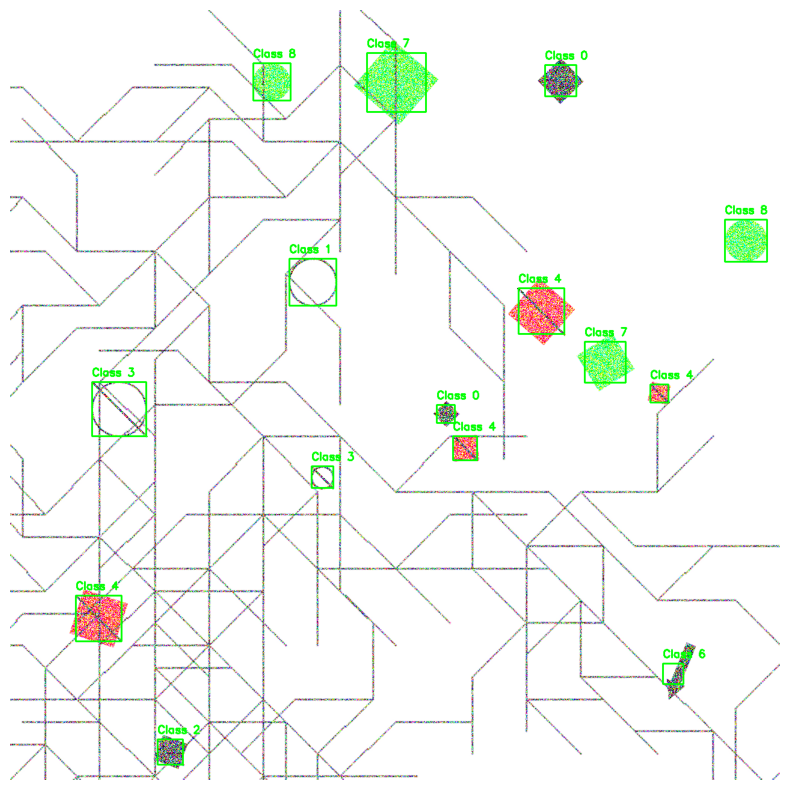

In [6]:
dataset_dir = "custom_generated_dataset_yolo_with_lines"
images_dir = os.path.join(dataset_dir, "images", "val")
labels_dir = os.path.join(dataset_dir, "labels", "val")

image_files = sorted(os.listdir(images_dir))
first_image_path = os.path.join(images_dir, image_files[0])
first_image = cv2.imread(first_image_path)

annotation_file = os.path.join(labels_dir, image_files[0].replace(".png", ".txt"))

with open(annotation_file, 'r') as f:
    annotations = f.readlines()

# parcourir les annotations et dessiner les boîtes de délimitation sur l'image
for annotation in annotations:
    class_id, x_center, y_center, width, height = map(float, annotation.split())
    
    # recup des coordonnées de la boîte en pixels
    img_h, img_w = first_image.shape[:2]
    box_x_center = int(x_center * img_w)
    box_y_center = int(y_center * img_h)
    box_width = int(width * img_w)
    box_height = int(height * img_h)

    # calcul des coins supérieurs gauche et inférieur droit de la boîte
    top_left = (box_x_center - box_width // 2, box_y_center - box_height // 2)
    bottom_right = (box_x_center + box_width // 2, box_y_center + box_height // 2)

    color = (0, 255, 0)  
    cv2.rectangle(first_image, top_left, bottom_right, color, 2)
    cv2.putText(first_image, f"Class {int(class_id)}", (top_left[0], top_left[1] - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

first_image_rgb = cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(first_image_rgb)
plt.show()

In [2]:
config_path = 'config.yaml' 
analyzer = DatasetAnalyzer(config_path)
analyzer.analyze_dataset()
analyzer.display_stats()

Statistiques du dataset :

Train set:
  Taille moyenne des images : 1280.0 x 1280.0
  Nombre total d'images : 400
  Nombre total d'individus dans toutes les classes : 19200
  Nombre d'individus par classe :
    Classe homme : 2166
    Classe femme : 2061
    Classe homme decede : 2102
    Classe femme decede : 2208
    Classe homme atteint decede : 2125
    Classe femme atteinte decedee : 2080
    Classe index : 2054
    Classe homme atteint : 2206
    Classe femme atteinte : 2198

Val set:
  Taille moyenne des images : 1280.0 x 1280.0
  Nombre total d'images : 50
  Nombre total d'individus dans toutes les classes : 2400
  Nombre d'individus par classe :
    Classe homme : 236
    Classe femme : 264
    Classe homme decede : 281
    Classe femme decede : 257
    Classe homme atteint decede : 268
    Classe femme atteinte decedee : 256
    Classe index : 285
    Classe homme atteint : 288
    Classe femme atteinte : 265

Test set:
  Taille moyenne des images : 1280.0 x 1280.0
  Nombre t